# Surface Mass Balance: XGB 

Import relevant Libaries 

In [119]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Using cached feature_engine-1.5.2-py2.py3-none-any.whl (290 kB)
  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\joblib-1.1.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [120]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
os.chdir('E:\GEUS-Master-Thesis')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

## Data Prep

In [293]:
import warnings
warnings.filterwarnings("ignore")

add_meta_data = False
csv_directory = "./../PROMICE-AWS-toolbox/out/test"
# List all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# Combine all CSV files into a single DataFrame
dfs = []
for f in csv_files:
    df = pd.read_csv(os.path.join(csv_directory, f), index_col=False)
    df.insert(0, 'stid', f[:-7])
    dfs.append(df)
df_hourly = pd.concat(dfs)

#df_hourly = pd.read_csv(r'./../PROMICE-AWS-toolbox/out/test/SCO_L_L4.csv', index_col=0)

#read metadata from promice repository
#station = pd.read_csv('../../PROMICE-AWS-toolbox/metadata/AWS_station_locations.csv', index_col=False)
#station.to_csv('../data/promice/new_promice/AWS_station_locations.csv', index=False)


#display(output station and columns summary)
print('Stations loaded:')
display(df_hourly['stid'].unique())
print('columns in dataset:')
print(list(df_hourly.columns))
print("FINISHED LOADING CSV's")

# Add year column to dataframe
df_hourly["Datetime"] = pd.to_datetime(df_hourly.time)
df_hourly["Datetime"] = pd.to_datetime(df_hourly["Datetime"], format="%Y-%m-%d %H:%M:%S")

#Rename Index Column to Datetime
df_hourly = df_hourly.reset_index(inplace=False)

if add_meta_data==True:
    add_nice_to_haves(df_hourly, 'hourly')

header = pd.read_csv('./metadata/promice_header.csv', sep = ";")
df_hourly = df_hourly.rename(columns = header.set_index('standard_name')['units']) #Units because headers are shifted
print(df_hourly.columns)

# This bit to detect Ablation
ablation = pd.DataFrame() # Create an empty dataframe to store the filtered and modified dataframes

# The next lines to format Datetime Correctly, assign it as index while still keeping it as a column
df_hourly['index'] = df_hourly.index
df_hourly["Datetime"] = pd.to_datetime(df_hourly["Datetime"], format="%Y-%m-%d %H:%M:%S")
df_hourly = df_hourly.rename(columns={'Datetime': 'Index_Datetime'})
df_hourly = df_hourly.set_index(['Index_Datetime'])
df_hourly['Datetime'] = df_hourly.index
df_hourly["Datetime"] = pd.to_datetime(df_hourly["Datetime"], format="%Y-%m-%d %H:%M:%S")

for station in df_hourly["stid"].unique():
    print("Calculating Ablation" , station)
    df_stid = df_hourly[df_hourly['stid'] == station].copy()

    # defining ice ablation period   
    smoothed_PT =  df_stid['Depth of pressure transducer in ice - corrected'].interpolate(limit=72).rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')
    smoothed_PT = smoothed_PT.rolling('14D', min_periods=1).mean().shift(-7*14/2, freq='h')

    threshold_ablation = -0.00001 # Modify value if needed
    ind_ablation = np.logical_and(smoothed_PT.diff().values < threshold_ablation, 
                                  np.isin(smoothed_PT.diff().index.month, [6, 7, 8, 9]))

    ind_ablation = np.concatenate((ind_ablation[4*24:], np.repeat(ind_ablation[-(4*24):-(4*24-1)], 4*24)))

    df_stid['Ablation'] = ind_ablation.tolist()
    df_stid['stid'] = station # Add a column for the current station
    ablation = ablation.append(df_stid[['Datetime', 'stid', 'Ablation']])


df_hourly = df_hourly.set_index(['index'])

# Merge the new column with the original dataframe based on datetime and station
df_hourly = pd.merge(df_hourly, ablation, on=['Datetime', 'stid'], how='left')

# This bit to add a beginning, middle & end of melting season attribute
beginning = 0.15
end = 0.85

melting_season = pd.DataFrame() # Create an empty dataframe to store the filtered and modified dataframes


for station in df_hourly["stid"].unique():

    print("Calculating Melting Season" , station)
    df_stid = df_hourly[df_hourly['stid'] == station].copy() 

    # Iterate over each year
    for year in df_stid['Datetime'].dt.year.unique():

        print("   Calculating" , year)

        # Get the dataframe for the current year
        year_df = df_stid[df_stid['Datetime'].dt.year == year]

        # Determine the threshold values for the beginning and end of the melting season
        ablation_df = year_df[year_df['Ablation'] == True]
        lower_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(beginning)
        upper_threshold = ablation_df['Datetime'].dt.dayofyear.quantile(end)

        # Set the Melting Season value for each row in the current year
        for index, row in year_df.iterrows():

            if row['Ablation'] == True:
                if row['Datetime'].dayofyear <= lower_threshold:
                    df_stid.loc[index, 'Melting Season'] = 'beginning'
                elif row['Datetime'].dayofyear >= upper_threshold:
                    df_stid.loc[index, 'Melting Season'] = 'end'
                else:
                    df_stid.loc[index, 'Melting Season'] = 'middle'

            elif (row['Datetime'] - pd.Timedelta(days=30)).dayofyear <= lower_threshold:
                df_stid.loc[index, 'Melting Season'] = 'pre'
            else:
                df_stid.loc[index, 'Melting Season'] = ''

    df_stid['stid'] = station # Add a column for the current station
    melting_season = melting_season.append(df_stid[['Datetime', 'stid', 'Melting Season']])

# Merge the new column with the original dataframe based on datetime and station
df_hourly = pd.merge(df_hourly, melting_season, on=['Datetime', 'stid'], how='left')

# Fill NAN values
df_hourly['Melting Season'] = df_hourly['Melting Season'].fillna('')


Stations loaded:


array(['KAN_L'], dtype=object)

columns in dataset:
['stid', 'time', 'p_u', 't_u', 'rh_u', 'rh_u_cor', 'qh_u', 'wspd_u', 'wdir_u', 'dsr', 'dsr_cor', 'usr', 'usr_cor', 'albedo', 'dlr', 'ulr', 'cc', 't_surf', 'dlhf_u', 'dshf_u', 'z_boom_u', 'z_stake', 'z_pt', 'z_pt_cor', 'precip_u', 'precip_u_cor', 't_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't_i_6', 't_i_7', 't_i_8', 'tilt_x', 'tilt_y', 'rot', 'gps_lat', 'gps_lon', 'gps_alt', 'gps_time', 'gps_geoid', 'gps_geounit', 'gps_hdop', 'gps_numsat', 'gps_q', 'batt_v', 'batt_v_ini', 'batt_v_ss', 'fan_dc_u', 'freq_vw', 't_log', 't_rad', 'msg_lat', 'msg_lon', 'z_pt_cor_adj_flag', 'z_surf_1', 'z_surf_2', 'z_surf_2_adj_flag', 'z_pt_cor_adj', 'z_surf_1_adj', 'z_surf_2_adj', 'z_surf_combined', 'depth_t_i_1', 'depth_t_i_2', 'depth_t_i_3', 'depth_t_i_4', 'depth_t_i_5', 'depth_t_i_6', 'depth_t_i_7', 'depth_t_i_8', 't_i_10m']
FINISHED LOADING CSV's
Index([                                                             'index',
                                                               

In [294]:
#df_hourly['index'] = df_hourly.index
#df_hourly["Datetime"] = pd.to_datetime(df_hourly["Datetime"], format="%Y-%m-%d %H:%M:%S")
#df_hourly = df_hourly.rename(columns={'Datetime': 'Index_Datetime'})
#df_hourly = df_hourly.set_index(['Index_Datetime'])
#df_hourly['Datetime'] = df_hourly.index
#df_hourly["Datetime"] = pd.to_datetime(df_hourly["Datetime"], format="%Y-%m-%d %H:%M:%S")

# Calculate the time differences in seconds between rows

#df_hourly['time_diff'] = df_hourly['Datetime'].diff().dt.total_seconds()

# Calculate the derivative of the 'Surface height from combined measurements' column


#df_hourly['derivative'] = df_hourly['Surface height from combined measurements'].diff() / df_hourly['time_diff']



#df_hourly['Surface height from combined measurements DELTA'] = np.gradient(
#    df_hourly['Surface height from combined measurements']
#    .rolling(center=False, window='D')
#    .mean()
#)

#df_hourly = df_hourly.set_index(['index'])

In [295]:
#This bit to add delta column 
delta = pd.DataFrame() # Create an empty dataframe to store the filtered and modified dataframes
df_hourly['Date'] = df_hourly['Datetime'].dt.date # Date to merge on

for station in df_hourly["stid"].unique():
    print("Calculating", station)
    df_stid = df_hourly[df_hourly['stid'] == station].copy()
    df_stid['Date'] = df_stid['Datetime'].dt.date # extract date component
    
    df_stid['Surface height from combined measurements DELTA'] = df_stid.groupby('Date')['Surface height from combined measurements'].transform(lambda x: (x.iloc[-1] - x.iloc[0]))
    #df_stid['Surface height from combined measurements DELTA'] = df_stid['Surface height from combined measurements'].diff()
    df_stid['stid'] = station # Add a column for the current station
    delta = delta.append(df_stid[['Datetime', 'stid', 'Surface height from combined measurements DELTA']])

# Merge the new column with the original dataframe based on datetime and station
df_hourly = pd.merge(df_hourly, delta, on=['Datetime', 'stid'], how='left')


# Remove not needed columns
df_hourly = df_hourly[[column for column in df_hourly.columns if column not in exclude_list]]

counter = 1
for station in df_hourly['stid'].unique():
    station_csv = df_hourly.loc[df_hourly['stid'] == station]
    station_csv.to_csv('./data/promice/preprocessed/hourly/{station}.csv'.format(station=station))
    counter += 1 

print("FINISHED PROCESSING HOURLY DATA")

Calculating KAN_L
FINISHED PROCESSING HOURLY DATA


In [296]:
dataframe=None
directory="./data/promice/preprocessed/hourly"    
add_meta_data=False   

if not isinstance(dataframe, pd.DataFrame):
    # List all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    # Combine all CSV files into a single DataFrame
    dfs = []
    for f in csv_files:
        df = pd.read_csv(os.path.join(directory, f), index_col=False)
        dfs.append(df)
        df = pd.concat(dfs)
    print('finished loading csvs')
else:
    df = dataframe.copy()

# remove the Unnamed columns...
df = df[[column for column in df.columns if column not in exclude_list]]

    #display(output station and columns summary)
print('Stations loaded:')
display(df['stid'].unique())
print('columns in dataset:')
print(list(df.columns))
print("FINISHED LOADING CSV's")

# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Group by 'stid' and daily frequency
daily_groups = df.groupby(['stid', pd.Grouper(key='Datetime', freq='D')])

# Define aggregation functions
agg_functions = {'Air pressure (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Air temperature (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Relative humidity (upper boom) - corrected': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Specific humidity (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Wind speed (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Wind from direction (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Downwelling shortwave radiation - corrected': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Upwelling shortwave radiation - corrected': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Downwelling longwave radiation': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Upwelling longwave radiation': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Surface temperature': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Latent heat flux (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Sensible heat flux (upper boom)': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Surface height from combined measurements': 'mean',
                 'Surface height from combined measurements DELTA': 'mean',
                 'Albedo': 'mean',
                 'Cloud cover': lambda x: x.mean() if len(x) > 20 else np.nan,
                 'Ablation': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
                 'Melting Season': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan}

# Apply aggregation functions to each group
df_daily = daily_groups.agg(agg_functions)

# Remove the multi-level index and reset the index
df_daily.reset_index(inplace=True)


print('columns in df_daily:')
print(list(df_daily.columns))

if add_meta_data==True:
    df_daily = add_nice_to_haves(df_daily, 'daily')


df_daily = df_daily[[column for column in df_daily.columns if column not in exclude_list]]

counter = 1
for station in df_daily['stid'].unique():
    station_csv = df_daily.loc[df_daily['stid'] == station]
    station_csv.to_csv('./data/promice/preprocessed/daily/{station}.csv'.format(station=station))
    counter += 1 

print("FINISHED PROCESSING DAILY DATA")

finished loading csvs
Stations loaded:


array(['SCO_L', 'KAN_L'], dtype=object)

columns in dataset:
['stid', 'Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - corrected', 'Albedo', 'Downwelling longwave radiation', 'Upwelling longwave radiation', 'Cloud cover', 'Surface temperature', 'Latent heat flux (upper boom)', 'Sensible heat flux (upper boom)', 'Surface height from combined measurements', 'Datetime', 'Ablation', 'Melting Season', 'Surface height from combined measurements DELTA']
FINISHED LOADING CSV's
columns in df_daily:
['stid', 'Datetime', 'Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - correc

In [297]:
# This bit to include only relevant features
exclude_list = [                                                   # 'index', # excluded because of unimportant information
                                                                   #  'stid', # excluded because of unimportant information
#                                                'Air pressure (upper boom)',
#                                             'Air temperature (upper boom)',
                                            'Relative humidity (upper boom)', # excluded because of corrected feature
#                               'Relative humidity (upper boom) - corrected',
#                                           'Specific humidity (upper boom)',
#                                                  'Wind speed (upper boom)',
#                                         'Wind from direction (upper boom)',
                                          'Downwelling shortwave radiation', # excluded because of corrected feature
#                              'Downwelling shortwave radiation - corrected',
                                            'Upwelling shortwave radiation', # excluded because of corrected feature
#                                'Upwelling shortwave radiation - corrected',
#                                                                   'Albedo', 
#                                           'Downwelling longwave radiation',
#                                             'Upwelling longwave radiation',
#                                                              'Cloud cover',
#                                                      'Surface temperature',
#                                            'Latent heat flux (upper boom)', 
#                                          'Sensible heat flux (upper boom)', 
                                                        'Upper boom height', # excluded because of unimportant information
                                                             'Stake height', # excluded due to missing values
                                      'Depth of pressure transducer in ice', # excluded due to derived correlation with y
                          'Depth of pressure transducer in ice - corrected', # excluded due to derived correlation with y
                   'Precipitation (upper boom) (cumulative solid & liquid)', # excluded because of corrected feature
       'Precipitation (upper boom) (cumulative solid & liquid) – corrected', # excluded due to missing values
                                              'Ice temperature at sensor 1', # excluded due to missing values
                                              'Ice temperature at sensor 2', # excluded due to missing values
                                              'Ice temperature at sensor 3', # excluded due to missing values
                                              'Ice temperature at sensor 4', # excluded due to missing values
                                              'Ice temperature at sensor 5', # excluded due to missing values
                                              'Ice temperature at sensor 6', # excluded due to missing values
                                              'Ice temperature at sensor 7', # excluded due to missing values
                                              'Ice temperature at sensor 8', # excluded due to missing values
                                                             'Tilt to east', # excluded because of unimportant information 
                                                            'Tilt to north', # excluded because of unimportant information
                                         'Station rotation from true North', # excluded because of unimportant information
                                                                 'Latitude', # excluded because of unimportant information
                                                                'Longitude', # excluded because of unimportant information
                                                                 'Altitude', # excluded because of unimportant information
                                                                 'GPS time', # excluded because of unimportant information 
                               'Height of EGM96 geoid over WGS84 ellipsoid', # excluded because of unimportant information
                                                                  'GeoUnit', # excluded because of unimportant information
                             'GPS horizontal dillution of precision (HDOP)', # excluded because of unimportant information
                                                 'GPS number of satellites', # excluded because of unimportant information
                                                                  'Quality', # excluded because of unimportant information
                                                          'Battery voltage', # excluded because of unimportant information
                                                                      'nan',
                                           'Battery voltage (sample start)', # excluded because of unimportant information
                                                 'Fan current (upper boom)', # excluded because of unimportant information
                       'Frequency of vibrating wire in precipitation gauge', # excluded because of unimportant information
                                                       'Logger temperature', # excluded because of unimportant information
                                             'Radiation sensor temperature', # excluded because of unimportant information
                                         'latitude from modem (email text)', # excluded because of unimportant information
                                        'longitude from modem (email text)', # excluded because of unimportant information
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                         'Surface height 1', # excluded due to derived correlation with y
                                                        'z_surf_1_adj_flag', # excluded due to derived correlation with y
                                                        'z_surf_2_adj_flag', # excluded due to derived correlation with y
#                                'Surface height from combined measurements', 
                                   'Depth of ice temperature measurement 1', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 2', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 3', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 4', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 5', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 6', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 7', # excluded because of unimportant information
                                   'Depth of ice temperature measurement 8', # excluded because of unimportant information
                               'Ice temperature interpolated at 10 m depth', # excluded due to missing values
                                                'Air pressure (lower boom)', # excluded due to missing values
                                             'Air temperature (lower boom)', # excluded due to missing values
                                           'Relative humidity (lower boom)', # excluded due to missing values
                               'Relative humidity (lower boom) - corrected', # excluded due to missing values
                                           'Specific humidity (lower boom)', # excluded due to missing values
                                                  'Wind speed (lower boom)', # excluded due to missing values
                                         'Wind from direction (lower boom)', # excluded due to missing values
                                            'Latent heat flux (lower boom)', # excluded due to missing values
                                          'Sensible heat flux (lower boom)', # excluded due to missing values
                                                        'Lower boom height', # excluded due to missing values
                   'Precipitation (lower boom) (cumulative solid & liquid)', # excluded due to missing values
       'Precipitation (lower boom) (cumulative solid & liquid) – corrected', # excluded due to missing values
                                              'Ice temperature at sensor 9', # excluded due to missing values
                                             'Ice temperature at sensor 10', # excluded due to missing values
                                             'Ice temperature at sensor 11', # excluded due to missing values
                                                 'Fan current (lower boom)', # excluded due to missing values
                                   'Depth of ice temperature measurement 9', # excluded due to missing values
                                  'Depth of ice temperature measurement 10', # excluded due to missing values
                                  'Depth of ice temperature measurement 11', # excluded due to missing values
                                                        'z_pt_cor_adj_flag', # excluded due to derived correlation with y
                              'Ice surface height adjusted for maintenance', # excluded due to derived correlation with y
                                'Surface height adjusted for maintenance 1', # excluded due to derived correlation with y
                                  'Surface height adjusted for maintenance', # excluded due to derived correlation with y
#                                                                 'Datetime',
#                                                                 'Ablation',  
#                          'Surface height from combined measurements DELTA'
                                                              'Unnamed: 18',# excluded because we do not know what it is
                                                                'month_num',# excluded because we do not know what it is
                                                                     'date',# excluded because we do not know what it is
                                                       'Surface height 1.1',# excluded because we do not know what it is
                                                              'Unnamed: 48',# excluded because we do not know what it is
                                                                     'Time',# excluded because we do not know what it is
                                                               'Unnamed: 0',
                                                              'Unnamed: 17',
                                                                     'Date',# excluded because we do not know what it is
                                                       
               ]

## Visualize Data

In [71]:
df = df_daily

#### With Bokeh

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
from bokeh.plotting import figure, output_file, save

def plt_srf_height(Station, input_df=df, y=df['Surface height from combined measurements'], Period="All"):
    df = input_df[input_df['stid'] == Station].copy()

    if Period != "All":
        start_date = Period[0]
        end_date = Period[1]
        df = df[df['Datetime'].between(start_date, end_date)]
        
    # Define the colors for the melting season categories
    colors = {'pre': 'grey', '': 'black', 'beginning': 'green', 'middle': 'orange', 'end': 'red'}
    categories = ['pre', '', 'beginning', 'middle', 'end']
    Y_name = y.name
    
    # Define the x-axis and y-axis values
    x = df['Datetime'].values
    y = y.fillna(-999).values
    
    if -999 in y:
        y_without_neg999 = [val for val in y if val != -999]
        minimum = min(y_without_neg999)
    else:
        minimum = min(y)

    data = {}
    for i, category in enumerate(categories):
        # Get the indices where the Melting Season column matches the current category
        indices = df[df['Melting Season'] == category].index
        
        # Create a ColumnDataSource for the current category
        source = ColumnDataSource({'x': x[indices], 'y': y[indices]})
        data[category] = source.data
    
    # Create a figure
    fig = figure(title=Station + " " , x_axis_label='Date', y_axis_label= Y_name, 
                 x_axis_type='datetime', width=1200, height=500,y_range=(minimum, max(y) + 2))

    # Iterate over the melting season categories and add a scatter plot for each category
    for i, category in enumerate(categories):
        fig.scatter('x', 'y', source=data[category], color=colors[category], alpha=0.7, 
                    legend_label=category, size=4)
    
    # Shade areas with "Ablation" = True
    ablation_mask = df["Ablation"]
    ablation_starts = df["Datetime"][ablation_mask & ~ablation_mask.shift(1, fill_value=False)]
    ablation_ends = df["Datetime"][ablation_mask & ~ablation_mask.shift(-1, fill_value=False)]
    for start, end in zip(ablation_starts, ablation_ends):
        fig.patch([start, end, end, start], [minimum, minimum, max(y), max(y)], fill_color='yellow', alpha=0.2, line_color=None)
    
    # Add a legend to the plot
    fig.legend.location = 'top_right'
    fig.legend.title = 'Melting Season'
    fig.legend.title_text_font_size = '14pt'
    fig.legend.label_text_font_size = '12pt'
    fig.legend.click_policy = 'hide'

    # Show the plot
    show(fig)
    

#### With Matplotlib

In [520]:
def plt_srf_height(Station, input_df=df, y=df['Surface height from combined measurements'], Period="All"):
    
    df = input_df[input_df['stid'] == Station].copy()  
    
    if Period != "All":
        start_date = Period[0]
        end_date = Period[1]
        df = df[df['Datetime'].between(start_date, end_date)]

    # Define the colors for the melting season categories
    colors = {'pre': 'grey', '': 'black', 'beginning': 'green', 'middle': 'orange', 'end': 'red'}
    categories = ['pre', '', 'beginning', 'middle', 'end']
    Y_name = y.name

    # Define the x-axis and y-axis values
    x = df['Datetime'].values
    y= y.values
    #y = y.fillna(-999).values

    #if -999 in y:
    #    y_without_neg999 = [val for val in y if val != -999]
    #    minimum = min(y_without_neg999)
    #else:
    #    minimum = min(y)
    
    minimum = min(y)
    
    data = {}
    for i, category in enumerate(categories):
        # Get the indices where the Melting Season column matches the current category
        indices = df[df['Melting Season'] == category].index

        # Add the x and y values for the current category to the dictionary
        data[category] = {'x': x[indices], 'y': y[indices]}

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 5))

    # Iterate over the melting season categories and add a scatter plot for each category
    for i, category in enumerate(categories):
        ax.scatter(data[category]['x'], data[category]['y'], c=colors[category], alpha=0.7, 
                   label=category, s=4)

    # Shade areas with "Ablation" = True
    ablation_mask = df["Ablation"]
    ablation_starts = df["Datetime"][ablation_mask & ~ablation_mask.shift(1, fill_value=False)]
    ablation_ends = df["Datetime"][ablation_mask & ~ablation_mask.shift(-1, fill_value=False)]
    for start, end in zip(ablation_starts, ablation_ends):
        ax.fill_between([start, end], [minimum, minimum], [max(y), max(y)], color='yellow', alpha=0.2, linewidth=0)

    # Set the x-axis and y-axis labels and limits
    ax.set_xlabel('Date')
    ax.set_ylabel(Y_name)
    #ax.set_xlim(min(x), max(x))
    ax.set_ylim(minimum, max(y) + 2)

    # Add a legend to the plot
    ax.legend(loc='upper right', title='Melting Season', fontsize=12, title_fontsize=14)

    # Show the plot
    plt.show()


In [ ]:
#df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
#df['Melting Season'] = df['Melting Season'].fillna('')

fig = plt_srf_height(Station = "KAN_L", input_df = df, y = df['seasonal']) 


## Time Series Decomposition

In [511]:
# https://datastud.dev/posts/python-seasonality-how-to

In [288]:
df = pd.read_csv('data/promice/preprocessed/daily/KAN_L.csv')

In [266]:
# Apply first-order differencing to remove trend
df['y_diff'] = df['Surface height from combined measurements'].diff()

# Apply seasonal differencing to remove seasonality (assuming the seasonality is 12 months)
df['y_diff_12'] = df['Surface height from combined measurements'].diff(365)


df['y_log'] = np.log(df['Surface height from combined measurements'])


invalid value encountered in log


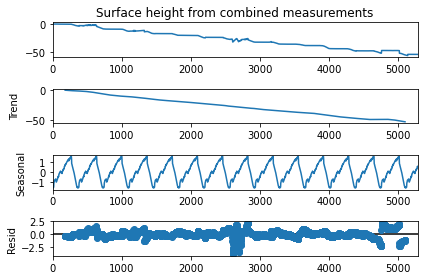

In [289]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["Surface height from combined measurements"], model="additive", period=365)

result.plot()
pyplot.show()

In [290]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

def plot_components(df):
    """Plot data for initial visualization, ultimately visualized in Power BI
    Args:
        df (pandas dataframe)
    """
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(10,10))

    plt.subplot(4,1,1)
    plt.title("Original Data")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.observed)

    plt.subplot(4,1,2)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,3)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,4)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [291]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    """Adds inplace new seasonal cols to df given seasonal results

    Args:
        input_df (pandas dataframe)
        seasonal_model_results (statsmodels DecomposeResult object)
    """
    # Add results to original df
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend
    input_df['seasonal_residual'] = input_df['seasonal'] + input_df['residual'] 



combine_seasonal_cols(df, result) # custom helper function

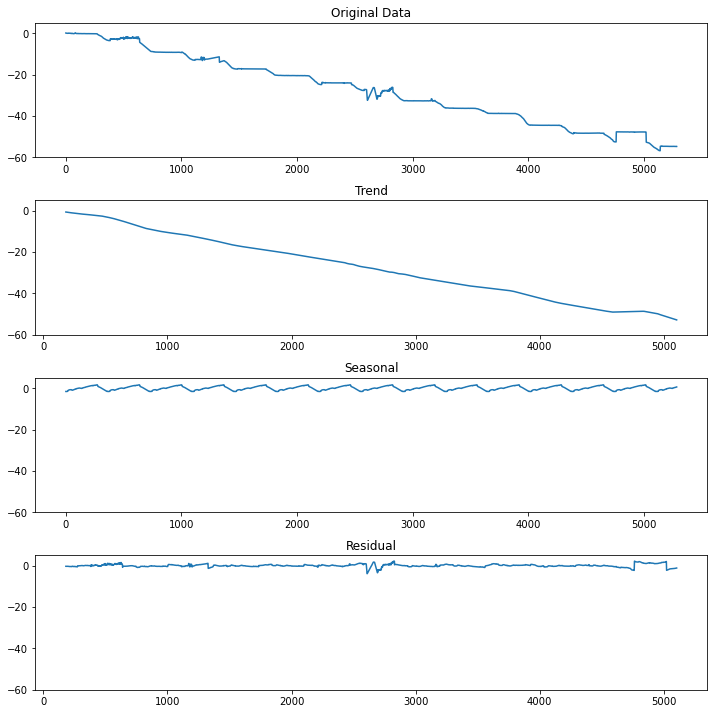

In [292]:
plot_components(df)

## Regression Analysis

##### Set target variable

In [293]:
y = 'seasonal_residual'

##### Pre-processing (0.1: Change months to cycle)

In [294]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [295]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
#df = df[df['Wind from direction (upper boom)'].notna()] 

# Exclude not needed columns in exclude list
#cyclical = cyclical.fit_transform(df[['month',  'day','Wind from direction (upper boom)']]) 

# Exclude not needed columns in exclude list
cyclical = cyclical.fit_transform(df[['month',  'day']]) 

df = pd.merge(df, cyclical, left_index=True, right_index=True)

#df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

ModuleNotFoundError: No module named 'feature_engine'

##### Pre-processing (1.0: Filter relevant periods)

In [296]:
df = df[df[y].notna()] 

In [297]:
# df = df[(df['Surface height from combined measurements DELTA'] < 0.4) & (df['Surface height from combined measurements DELTA'] > -0.4)]


In [298]:
#Only Ablation Period Or Melting Season

#df = df[df['Ablation'] == True]
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#Remove all NA values if training should be done only on ablation
#df = df.dropna()

df = df.reset_index(drop=True)

In [299]:
# This bit retrieve the indexes for all melting season categories and remove column from df
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

##### Pre-processing (2.0: Formatting and transformation)

In [300]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['Melting Season'] = le.fit_transform(df['Melting Season'])
dict(zip(le.classes_, le.transform(le.classes_)))

{'beginning': 0, 'end': 1, 'middle': 2, 'no_ablation': 3, 'pre': 4}

In [301]:
# This bit to include only relevant features


exclude_list = ['index', # excluded because of unimportant information
                'stid', # excluded because of unimportant information
                'Unnamed: 0', # Old Index
                'Ablation',
             'Melting Season', # We drop melting season later 
                'month',
                #'y_diff',
                #'y_diff_12',
                #'y_log',
                'month_sin',  #check if this makes a difference
                'month_cos',  #check if this makes a difference
                'day', 
               # 'day_sin',
               # 'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
               # 'seasonal_residual'
               'trend'
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [302]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual'
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [303]:
num_cols

Index(['Air pressure (upper boom)', 'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover'],
      dtype='object')

In [304]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop([y], axis=1), df[y],
    test_size=0.3, random_state=42, shuffle=False)

In [305]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split the data into training and testing sets while maintaining the subgroup distribution
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

#for train_index, test_index in split.split(df, df['Melting Season']):
#    delta_train = df.loc[train_index]
#    delta_test = df.loc[test_index]

# separate the features and target variables for the train and test sets
#X_train_ = delta_train.drop([y, 'Melting Season'], axis=1)
#y_train_ = delta_train[y]
#X_test_ = delta_test.drop([y, 'Melting Season'], axis=1)
#y_test_ = delta_test[y]

## CNN

In [284]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

# Replace NaN values with the mean of the non-NaN values
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_train))

# Reshape the input data to add a channel dimension
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Define the MLP CNN architecture
model = tf.keras.models.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=1)
])

# Compile the model with mean squared error loss and R-squared metric
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test data and print the results for MSE and R^2
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {test_loss:.4f}')



Epoch 1/10
108/108 [==============================] - 2s 3ms/step - loss: 2.1442
Epoch 2/10
108/108 [==============================] - 0s 3ms/step - loss: 1.0267
Epoch 3/10
108/108 [==============================] - 0s 2ms/step - loss: 0.9797
Epoch 4/10
108/108 [==============================] - 0s 3ms/step - loss: 1.0754
Epoch 5/10
108/108 [==============================] - 0s 2ms/step - loss: 0.9452
Epoch 6/10
108/108 [==============================] - 0s 3ms/step - loss: 0.9361
Epoch 7/10
108/108 [==============================] - 0s 2ms/step - loss: 0.8944
Epoch 8/10
108/108 [==============================] - 0s 3ms/step - loss: 0.8831
Epoch 9/10
108/108 [==============================] - 0s 3ms/step - loss: 0.8959
Epoch 10/10
108/108 [==============================] - 0s 2ms/step - loss: 0.8221
Test MSE: 1.5327


In [285]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r2)
print(mse)

0.12999475862014664
1.532721454777502


## LSTM

In [231]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Assuming the input data has shape (num_samples, num_timesteps, num_features)
num_timesteps = X_train.shape[1]
num_features = X_train.shape[2]

# Define the LSTM model architecture
model = tf.keras.models.Sequential([
    LSTM(units=64, activation='tanh', input_shape=(num_timesteps, num_features)),
    Dense(units=1)
])

# Compile the model with mean squared error loss
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test data and print the results for MSE and R^2
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {test_loss:.4f}')




Epoch 1/10
116/116 [==============================] - 4s 10ms/step - loss: 0.0127
Epoch 2/10
116/116 [==============================] - 1s 9ms/step - loss: 3.6292e-04
Epoch 3/10
116/116 [==============================] - 1s 9ms/step - loss: 2.6754e-04
Epoch 4/10
116/116 [==============================] - 1s 10ms/step - loss: 2.2010e-04
Epoch 5/10
116/116 [==============================] - 1s 9ms/step - loss: 2.1500e-04
Epoch 6/10
116/116 [==============================] - 1s 10ms/step - loss: 2.0764e-04
Epoch 7/10
116/116 [==============================] - 1s 10ms/step - loss: 2.0117e-04
Epoch 8/10
116/116 [==============================] - 1s 10ms/step - loss: 1.8901e-04
Epoch 9/10
116/116 [==============================] - 1s 10ms/step - loss: 1.9126e-04
Epoch 10/10
116/116 [==============================] - 1s 10ms/step - loss: 1.8224e-04
Test MSE: 0.0005


## XGB Regression Modelling

In [306]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



In [307]:
# Define Scope
#indices = eval(f"indices_all")  

# Find common indexes
#X_Train_valid_indices = indices.intersection(X_train_.index)
#y_Train_valid_indices = indices.intersection(y_train_.index)
#X_Test_valid_indices = indices.intersection(X_test_.index)
#y_Test_valid_indices = indices.intersection(y_test_.index)

# filter out by indeces
#X_train = X_train_.loc[X_Train_valid_indices]  
#y_train = y_train_.loc[y_Train_valid_indices] 
#X_test = X_test_.loc[X_Test_valid_indices]  
#y_test = y_test_.loc[y_Test_valid_indices]

-------

In [308]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [7], #[3, 5, 7],
    'min_child_weight': [5], #[1, 3, 5],
    'learning_rate': [0.1], #[0.1, 0.01, 0.001],
    'n_estimators': [100], #[100, 500, 1000],
    'subsample': [0.5], #[0.5, 0.7, 1.0],
    'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
    'reg_alpha': [0.5], #[0, 0.1, 0.5],
    'reg_lambda': [0.1], #[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)

# Save the best model parameters as 'model' variable
exec(f"model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 score on test set ({y}): ", r2)
print(f"MSE on test set ({y}): ", mse)

Best hyperparameters_seasonal_residual:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (seasonal_residual):  0.26453333030602566
MSE on test set (seasonal_residual):  1.295699715700376


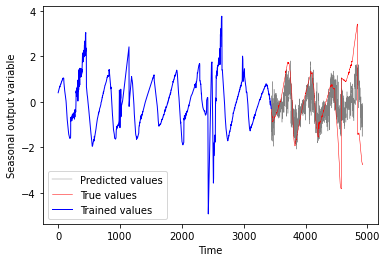

In [309]:
# Plot the seasonal output variable, trained values, tested values, and predicted values
plt.plot(y_test.index, y_pred, label='Predicted values', color='grey', linewidth=0.4)
plt.plot(y_test.index, y_test, label='True values', color='red', linewidth=0.5)
plt.plot(y_train.index, y_train, label='Trained values', color='blue', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Seasonal output variable')
plt.legend()
plt.show()

## Filter by Melting Season and get feature importances 

In [310]:
pd.DataFrame(shap_values_filtered.values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.004097,0.015456,-0.019921,0.020404,-0.070621,-0.016100,-0.130447,-0.220981,-0.018710,-0.040744,-0.009044,-0.004307,-0.042597,-0.140635,0.003364,0.069943,0.149196,0.0
1,-0.003989,0.025926,-0.036217,-0.253086,-0.069292,-0.007364,-0.067179,-0.278782,-0.013933,-0.062124,-0.035851,-0.018911,-0.069952,-0.080481,0.062692,0.230762,0.135330,0.0
2,-0.032066,-0.009735,-0.022182,-0.199474,-0.080687,0.148940,-0.119703,-0.236136,-0.021587,-0.079801,-0.038231,-0.027967,-0.074993,-0.131089,0.065205,0.062414,0.032740,0.0
3,-0.036371,0.001719,0.027025,-0.037260,-0.086872,-0.110399,-0.113389,-0.186594,-0.035325,-0.040049,0.015098,-0.018261,-0.055341,-0.126044,0.043875,0.066874,0.076880,0.0
4,-0.043703,-0.036978,0.010630,0.044270,-0.068879,0.019467,-0.077803,-0.259698,-0.053571,-0.025653,0.024116,-0.032128,-0.075777,-0.076668,0.049414,0.075415,0.100761,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,0.075978,0.021705,0.006437,0.171826,-0.051317,-0.008560,-0.159787,-0.271257,-0.014929,0.023759,0.033403,0.009554,-0.047440,-0.030949,0.074044,0.022738,-0.028551,0.0
1177,0.010279,0.027638,-0.043841,0.166038,-0.018941,0.002683,-0.184172,-0.276121,-0.022811,0.020930,0.035111,-0.004914,-0.054501,-0.031418,0.096081,0.039569,-0.017973,0.0
1178,-0.027495,0.047877,-0.004921,0.205977,-0.046361,0.030027,-0.169639,-0.275475,0.012813,0.035994,0.025470,0.008435,-0.040161,-0.030882,0.098872,0.044822,-0.032270,0.0
1179,-0.031266,0.073021,0.013714,0.257397,-0.053054,-0.049952,-0.172041,-0.281855,-0.040771,0.024395,0.069884,0.020526,-0.034566,-0.016320,-0.075273,-0.040624,-0.038333,0.0


In [311]:
import shap
explainer = eval(f"shap.Explainer(model_{y})")
#explainer_model = shap.Explainer(model)

# compute the SHAP values for a set of input data
#shap_values = explainer(X_filtered)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


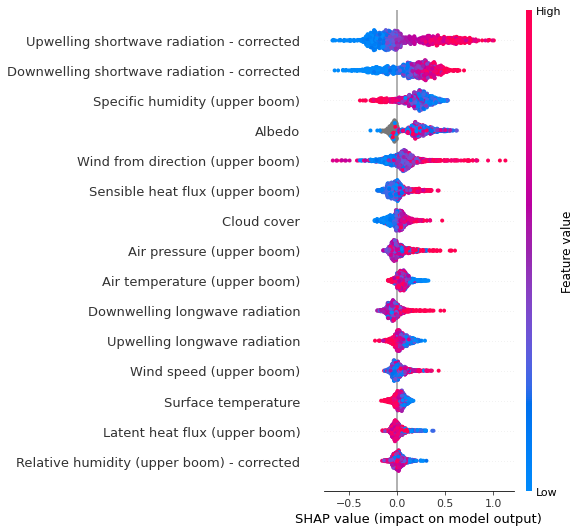

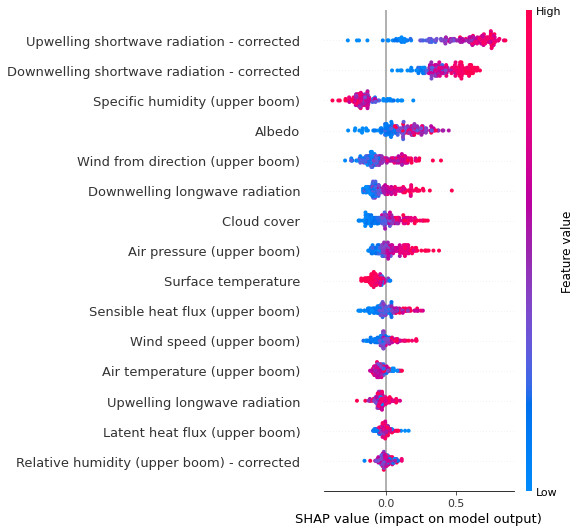

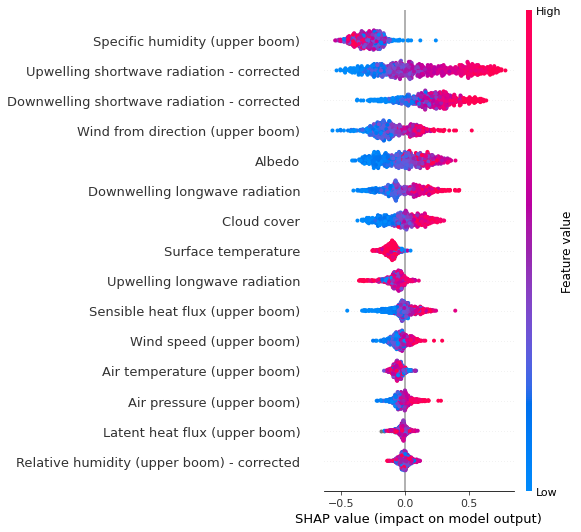

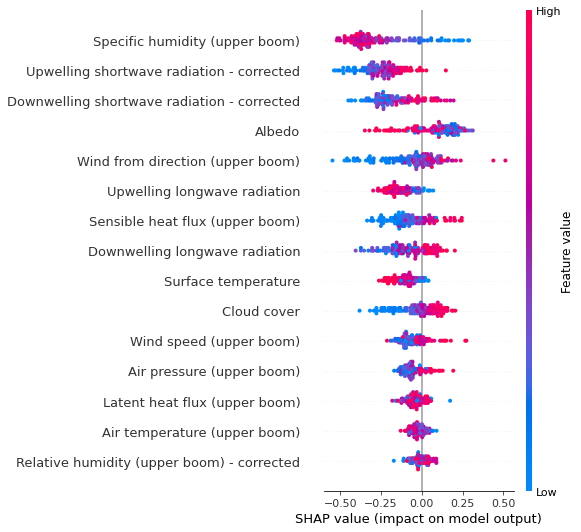

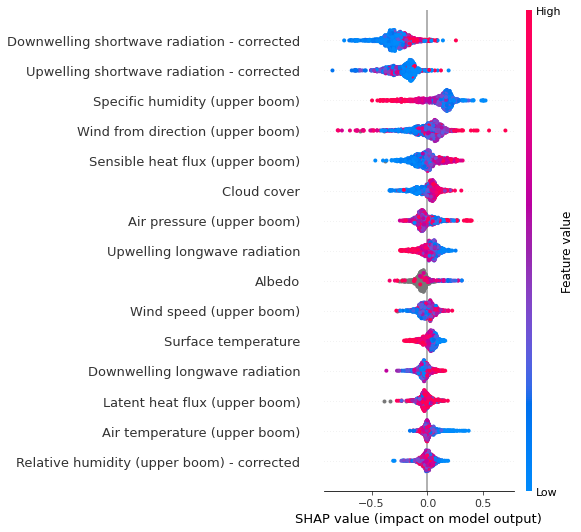

In [312]:
for category in ['pre', 'beginning', 'middle', 'end', 'no_ablation']:
    # Get the indices for the current category
    indices = eval(f"indices_{category}")
    
    # Filter X_train and shap_values based on the selected indices
    X_Train_valid_indices = indices.intersection(X_train.index).to_list()
    X_train_filtered = X_train.iloc[X_Train_valid_indices]
    shap_values_filtered = explainer(X_train_filtered)

    # Plot the force plot for the selected indices
    #shap.force_plot(explainer.expected_value, shap_values_filtered, X_train_filtered)
    shap.summary_plot(shap_values_filtered, X_train_filtered)

In [329]:
shap.initjs()

In [341]:
shap.force_plot(explainer.expected_value, shap_values)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [336]:
# Use the shap.TreeExplainer() function to create an object that can calculate SHAP values for the XGB regression model
explainer = shap.TreeExplainer(model)


In [337]:
# Use the shap_values() function to calculate the SHAP values for the input variables of the test set
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


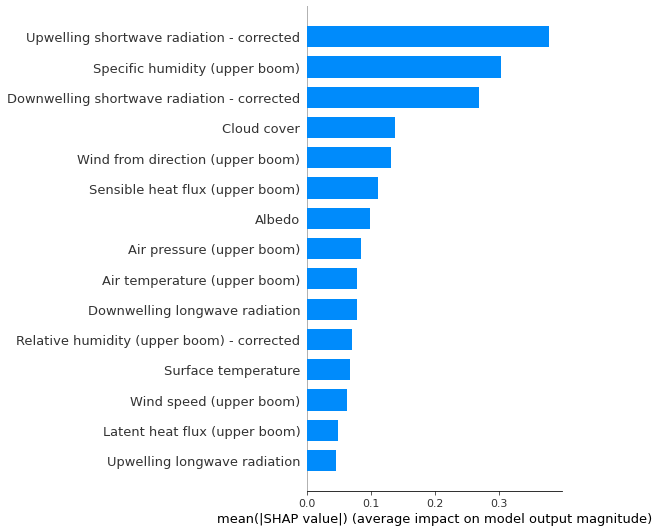

In [338]:
# Plot the SHAP summary plot using the shap.summary_plot() function
shap.summary_plot(shap_values, X_test, plot_type='bar')

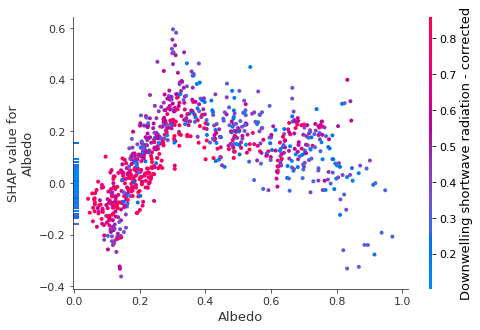

In [339]:
# Plot the SHAP dependence plots using the shap.dependence_plot() function
shap.dependence_plot('Albedo', shap_values, X_test)

In [ ]:
clustering = shap.utils.hclust(X_train, y_train)

shap.plots.bar(shap_values, clustering=clustering)


In [ ]:
lgbm_params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 70, 100, 150],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_samples': [10, 20, 30, 50, 80, 100],
    'reg_alpha': [0, 0.1, 0.5, 1, 2],
    'reg_lambda': [0, 0.1, 0.5, 1, 2]
}

In [ ]:
hgb_params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300, 400, 500],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [10, 20, 30, 50, 80, 100],
    'max_leaf_nodes': [20, 31, 50, 70, 100, 150]
}

In [ ]:
xgb_params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}